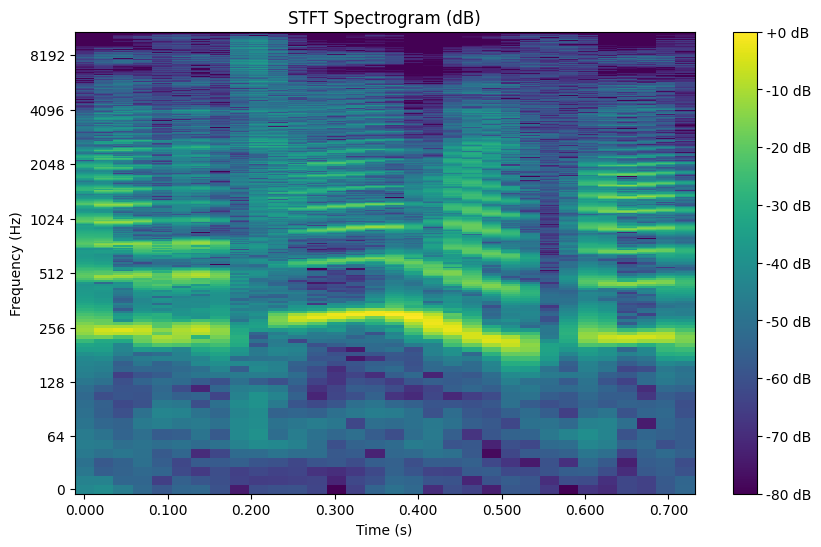

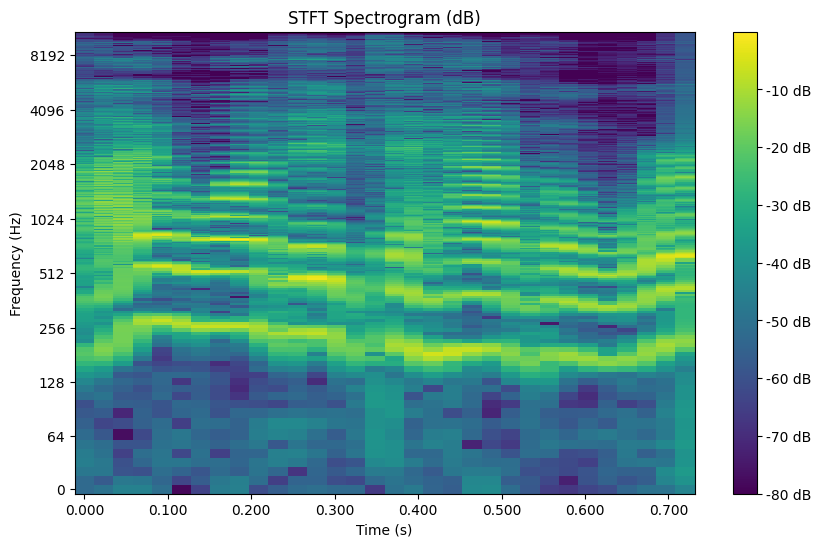

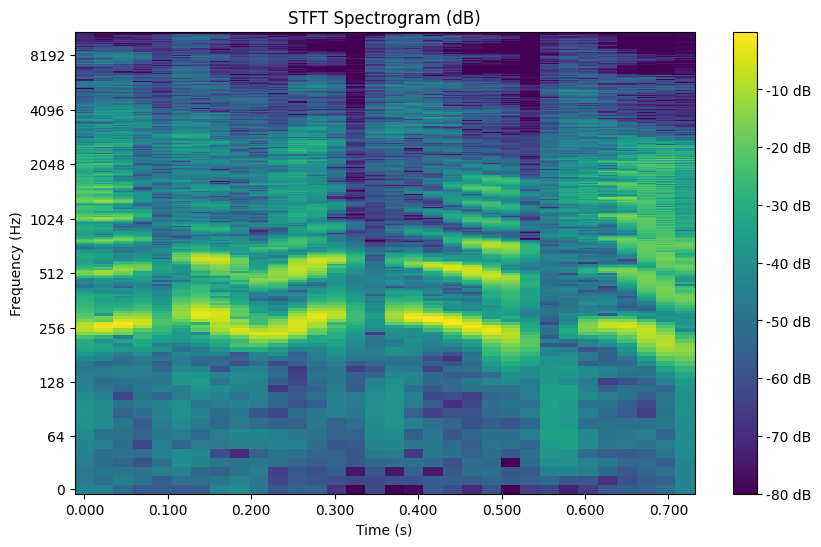

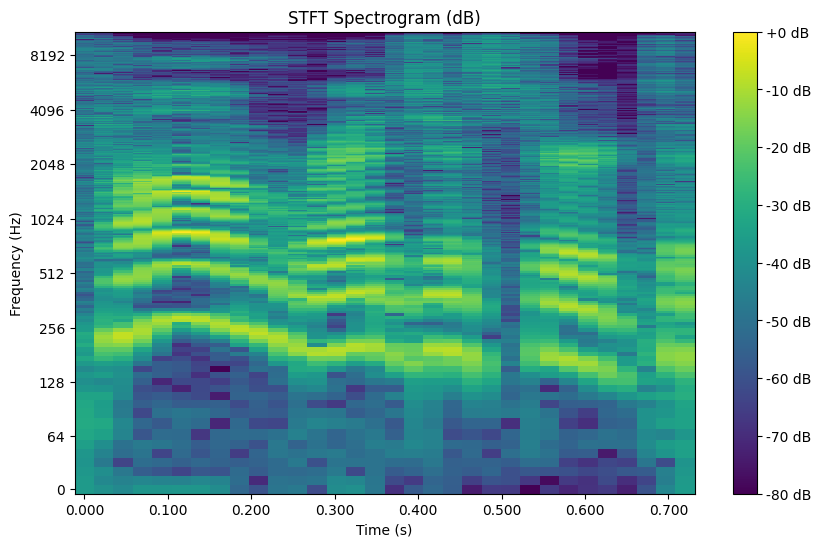

In [24]:

from matplotlib import pyplot as plt
import os
import librosa
import numpy as np
from scipy.signal import spectrogram

SAMPLE_RATE = 16000
DURATION = 1

path = 'audio_files/for-2sec/for-2seconds'

def process_audio_files(file, sampling = True):
    testing = []
    training = []
    validation = []
    counter = 0
        
    for dirpath, dirnames, filenames in os.walk(file):
        for filename in filenames:
            if sampling and counter > 100:
                break
            else:
                counter += 1
                filepath = os.path.join(dirpath, filename)
                if 'testing' in dirpath:
                    testing.append(convert_to_spectrogram(filepath))
                elif 'training' in dirpath:
                    training.append(convert_to_spectrogram(filepath))
                else:
                    validation.append(convert_to_spectrogram(filepath))

    return testing, training, validation

def convert_to_spectrogram(filepath):
    audio, _ = librosa.load(filepath, sr=SAMPLE_RATE, duration=DURATION)
    spec = librosa.stft(audio)
    return librosa.amplitude_to_db(np.abs(spec), ref=np.max)

def print_sample_spec(index):
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(index, x_axis='time', y_axis='log', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title('STFT Spectrogram (dB)')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

test, train, val = process_audio_files(path)

print_sample_spec(test[3])
print_sample_spec(test[4])
print_sample_spec(test[99])
print_sample_spec(test[98])

